In [28]:
%load_ext autoreload
%autoreload 2

import torch

import matplotlib.pyplot as plt
import seaborn as sns

from data_utils import *

from mixture_model.model import MixtureModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mixture_model = MixtureModel.from_pretrained("./checkpoints/mixture_model_20240611_223628.pt").to(device)
mixture_model.eval()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


MixtureModel(
  (encoder): MixtureModelEncoder(
    (gnn_layers): ModuleList(
      (0): ECGConv(4, 16)
      (1): BatchNorm(16)
      (2): GELU(approximate='none')
      (3): ECGConv(16, 32)
      (4): BatchNorm(32)
      (5): GELU(approximate='none')
      (6): ECGConv(32, 64)
      (7): BatchNorm(64)
      (8): GELU(approximate='none')
      (9): ECGConv(64, 128)
      (10): BatchNorm(128)
      (11): GELU(approximate='none')
    )
    (z_head): ResidualBlock(
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
        (3): Dropout(p=0, inplace=False)
        (4): Linear(in_features=128, out_features=32, bias=True)
      )
      (residual): Linear(in_features=128, out_features=32, bias=True)
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): GELU(

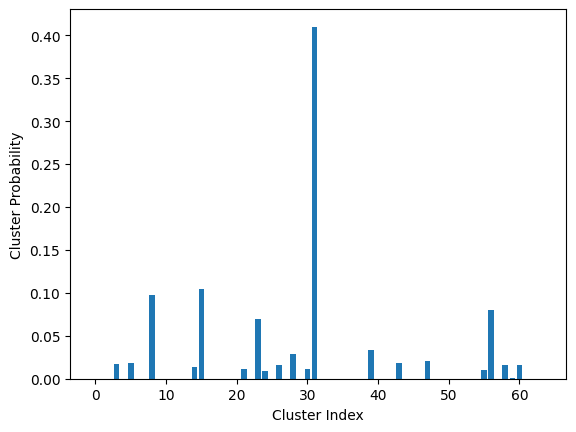

: 

In [29]:
pi = mixture_model.decoder.get_pi().detach().cpu().numpy()[0]
plt.bar(list(range(0, 64)), pi)
plt.ylabel("Cluster Probability")
plt.xlabel("Cluster Index")
plt.show()

In [20]:
prop_norm_df = create_or_load_property_norm_df()
dataset = create_qm9_mixture_vae_dataset(
    device=device, 
    include_hydrogen=False,
    refresh_data_cache=False,
    properties=None,
    prop_norm_df=prop_norm_df
)
train_dataset, val_dataset, _ = create_qm9_data_split(dataset=dataset)

batch_size = 4096
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [21]:
num_generated_mols = 10000
num_atoms = torch.tensor([9] * num_generated_mols, dtype=torch.int64, device=device)

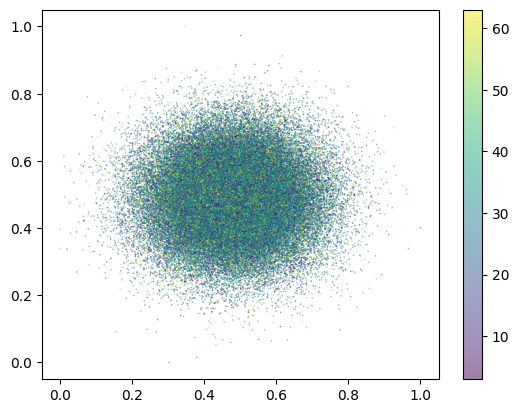

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

pi = mixture_model.decoder.get_pi()
c = mixture_model.decoder.sample_c(pi=pi, num_atoms=num_atoms)
z = mixture_model.decoder.sample_z(c=c).detach().cpu().numpy()

cluster_labels = np.argmax(c.detach().cpu().numpy(), axis=1)

pca_fitted = PCA(n_components=2).fit(z)
Z_pca = pca_fitted.transform(z)
Z_pca = MinMaxScaler().fit_transform(Z_pca)
df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']

scatter = plt.scatter(x=df['x'], y=df['y'], c=cluster_labels, marker='.', s=5, alpha=0.5, edgecolors='none', cmap='viridis')
plt.colorbar(scatter)
plt.show()

In [13]:
means = mixture_model.decoder.cluster_means.detach().cpu()[0]

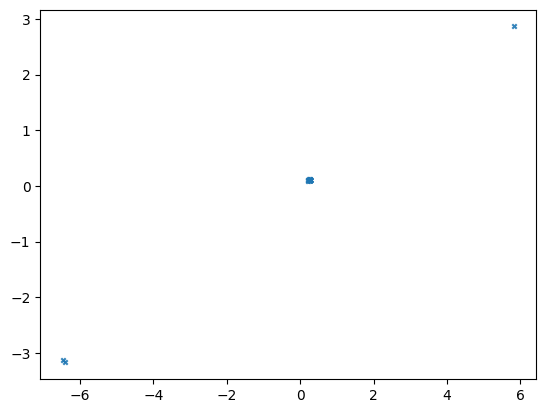

In [14]:
# do pca and normalize
Z_pca = pca_fitted.transform(means)
#Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']

scatter = plt.scatter(x=df['x'], y=df['y'], marker='x',
            s=10,alpha=0.9)
plt.show()